#### Часть 1. EDA и Preprocessing.

- Скачайте данные по клиентам немецкого банка: https://www.kaggle.com/uciml/german-credit;
- Проведите EDA, чтобы познакомиться с признаками;
- Преобразуйте все признаки в числовые подходящими методами;
- Приведите все данные к одному масштабу (а заодно поясните, почему это необходимая операция при кластеризации).

#### Часть 2. Моделирование.
- Постройте три варианта кластеризации: k-means, hierarhical и DBSCAN, подберите оптимальное количество кластеров для каждого метода при помощи Elbow method и Silhouette plot;
- Также воспользуйтесь различными вариантами сжатия признакового пространства (PCA, UMAP, tSNE) и визуализируйте результаты кластеризации на двумерной плоскости.

#### Часть 3. Интерпретация.
- Теперь ваша задача - попытаться проинтерпретировать получившиеся кластеры, начните с простого расчета средних значений признаков для каждого из кластеров, есть ли интересные закономерности?
- Теперь постройте boxplot-ы для каждого признака, сгруппировав значения по кластерам, по каким признакам заметно наибольшее отличие кластеров друг от друга? Можно ли их интерпретировать?

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotly import express as px
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('data/german_credit_data.csv', index_col=0)

The selected attributes are:

    1. Age (numeric);
    2. Sex (text: male, female);
    3. Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled);
    4. Housing (text: own, rent, or free);
    5. Saving accounts (text - little, moderate, quite rich, rich);
    6. Checking account (numeric, in DM - Deutsch Mark);
    7. Credit amount (numeric, in DM);
    8. Duration (numeric, in month);
    9. Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others);

In [3]:
df

Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0     67    male    2     own             NaN           little           1169   
1     22  female    2     own          little         moderate           5951   
2     49    male    1     own          little              NaN           2096   
3     45    male    2    free          little           little           7882   
4     53    male    2    free          little           little           4870   
..   ...     ...  ...     ...             ...              ...            ...   
995   31  female    1     own          little              NaN           1736   
996   40    male    3     own          little           little           3857   
997   38    male    2     own          little              NaN            804   
998   23    male    2    free          little           little           1845   
999   27    male    2     own        moderate         moderate           4576   

     Duration              Purpose  
0           6             radio/TV  
1          48             radio/TV  
2          12            education  
3          42  furniture/equipment  
4          24                  car  
..        ...                  ...  
995        12  furniture/equipment  
996        30                  car  
997        12             radio/TV  
998        45             radio/TV  
999        45                  car  

[1000 rows x 9 columns]

In [4]:
df.shape

(1000, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 78.1+ KB


In [6]:
df.describe()

Age          Job  Credit amount     Duration
count  1000.000000  1000.000000    1000.000000  1000.000000
mean     35.546000     1.904000    3271.258000    20.903000
std      11.375469     0.653614    2822.736876    12.058814
min      19.000000     0.000000     250.000000     4.000000
25%      27.000000     2.000000    1365.500000    12.000000
50%      33.000000     2.000000    2319.500000    18.000000
75%      42.000000     2.000000    3972.250000    24.000000
max      75.000000     3.000000   18424.000000    72.000000

In [7]:
df.describe(include='object')

Sex Housing Saving accounts Checking account Purpose
count   1000    1000             817              606    1000
unique     2       3               4                3       8
top     male     own          little           little     car
freq     690     713             603              274     337

Посмотрим на уникальные значения категориальных прихнаков

In [8]:
df.isna().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64

## EDA & Preprocessing

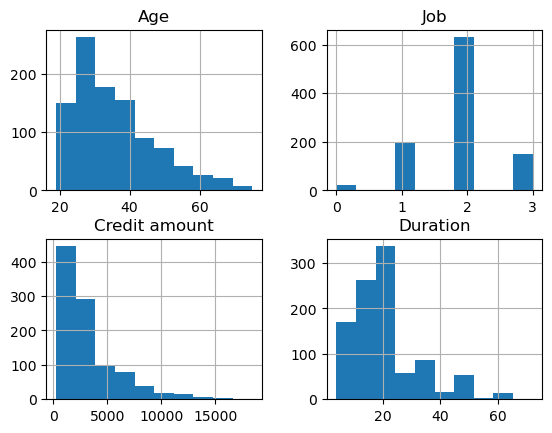

In [9]:
df.hist();

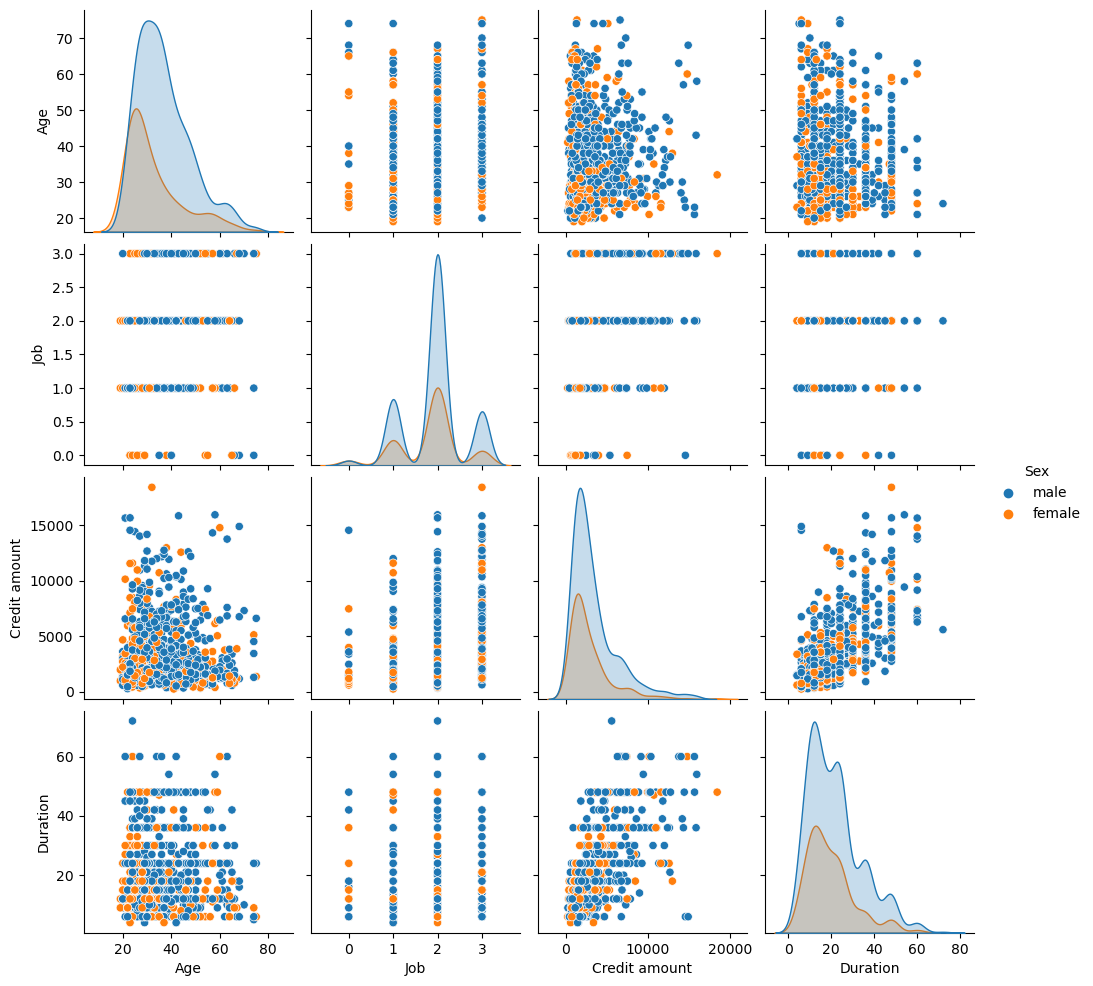

In [10]:
sns.pairplot(df, hue='Sex');

In [11]:
gr_credits = df.groupby('Purpose')['Age'].count().rename('Count')

In [12]:
gr_credits

Purpose
business                97
car                    337
domestic appliances     12
education               59
furniture/equipment    181
radio/TV               280
repairs                 22
vacation/others         12
Name: Count, dtype: int64

Посмотрим на распределение количества выданных кредитов по целям

In [13]:
n_credits = df.groupby('Purpose')['Age'].count().rename('Count').reset_index()

In [14]:
n_credits

Purpose  Count
0             business     97
1                  car    337
2  domestic appliances     12
3            education     59
4  furniture/equipment    181
5             radio/TV    280
6              repairs     22
7      vacation/others     12

In [15]:
n_credits.sort_values(by=['Count'], ascending=False, inplace=True)

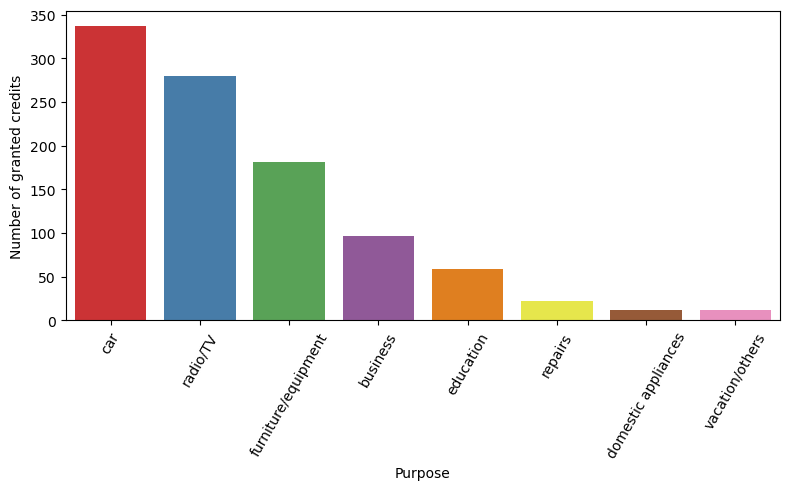

In [16]:
plt.figure(figsize=(8,5))
bar = sns.barplot(x='Purpose', y='Count', data=n_credits, palette='Set1')
bar.set_xticklabels(bar.get_xticklabels(), rotation=60)
plt.ylabel('Number of granted credits')
plt.tight_layout()

Закодируем категориальные признаки

In [17]:
for col in df.select_dtypes(include='object'):
    print(col,":", df[col].unique())

Sex : ['male' 'female']
Housing : ['own' 'free' 'rent']
Saving accounts : [nan 'little' 'quite rich' 'rich' 'moderate']
Checking account : ['little' 'moderate' nan 'rich']
Purpose : ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']


Перекодируем пол

In [18]:
df['Sex'] = df['Sex'].apply(lambda x: 1 if x == 'male' else 0)

In [19]:
df

Age  Sex  Job Housing Saving accounts Checking account  Credit amount  \
0     67    1    2     own             NaN           little           1169   
1     22    0    2     own          little         moderate           5951   
2     49    1    1     own          little              NaN           2096   
3     45    1    2    free          little           little           7882   
4     53    1    2    free          little           little           4870   
..   ...  ...  ...     ...             ...              ...            ...   
995   31    0    1     own          little              NaN           1736   
996   40    1    3     own          little           little           3857   
997   38    1    2     own          little              NaN            804   
998   23    1    2    free          little           little           1845   
999   27    1    2     own        moderate         moderate           4576   

     Duration              Purpose  
0           6             radio/TV  
1          48             radio/TV  
2          12            education  
3          42  furniture/equipment  
4          24                  car  
..        ...                  ...  
995        12  furniture/equipment  
996        30                  car  
997        12             radio/TV  
998        45             radio/TV  
999        45                  car  

[1000 rows x 9 columns]

Небинарные признаки перекодируем с использованием OrdinalEncoder, Null-значения заменим -1

In [20]:
enc = OrdinalEncoder(dtype=np.int64, encoded_missing_value=-1)

In [21]:
df[['Housing','Saving accounts','Checking account','Purpose']] = enc.fit_transform(df[['Housing','Saving accounts','Checking account','Purpose']])

In [22]:
df

Age  Sex  Job  Housing  Saving accounts  Checking account  Credit amount  \
0     67    1    2        1               -1                 0           1169   
1     22    0    2        1                0                 1           5951   
2     49    1    1        1                0                -1           2096   
3     45    1    2        0                0                 0           7882   
4     53    1    2        0                0                 0           4870   
..   ...  ...  ...      ...              ...               ...            ...   
995   31    0    1        1                0                -1           1736   
996   40    1    3        1                0                 0           3857   
997   38    1    2        1                0                -1            804   
998   23    1    2        0                0                 0           1845   
999   27    1    2        1                1                 1           4576   

     Duration  Purpose  
0           6        5  
1          48        5  
2          12        3  
3          42        4  
4          24        1  
..        ...      ...  
995        12        4  
996        30        1  
997        12        5  
998        45        5  
999        45        1  

[1000 rows x 9 columns]

In [23]:
df.isna().sum()

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
dtype: int64

Посмотрим на корреляцию в данных

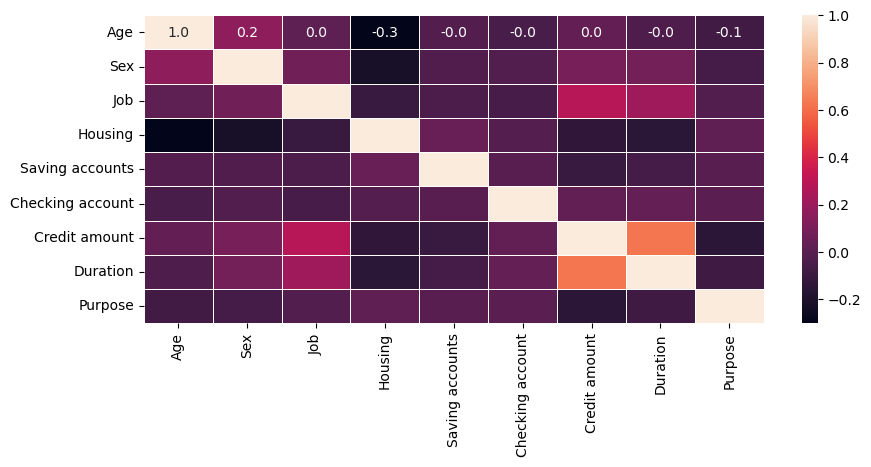

In [24]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax);

Выберем признаки, корреляция Пирсона для которых превышает 0.6

In [25]:
stacked = df.corr().stack()

In [26]:
stacked[((stacked > 0.6) | (stacked < -0.6)) & (stacked != 1)]

Credit amount  Duration         0.624984
Duration       Credit amount    0.624984
dtype: float64

Признаки сумма кредита и длительность скоррелированы, что вполне логично, но корреляция не очень большая, 0.62

Проведем нормализацию данных

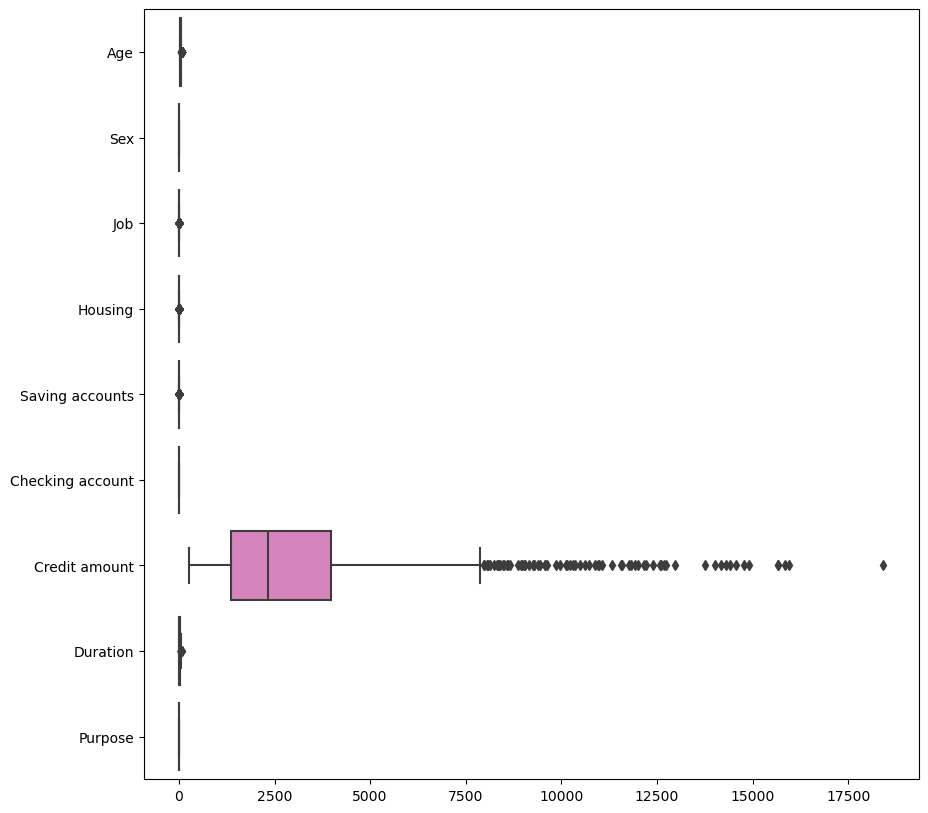

In [27]:
plt.figure(figsize=(10,10))
sns.boxplot(data=df, orient='h');

In [28]:
X = df

In [29]:
X_scaled = StandardScaler().fit_transform(X)

In [30]:
X_scaled.shape

(1000, 9)

In [31]:
df_scaled = pd.DataFrame(X_scaled, columns=df.columns)

In [32]:
df_scaled

Age       Sex       Job   Housing  Saving accounts  \
0    2.766456  0.670280  0.146949 -0.133710        -1.231393   
1   -1.191404 -1.491914  0.146949 -0.133710        -0.196609   
2    1.183312  0.670280 -1.383771 -0.133710        -0.196609   
3    0.831502  0.670280  0.146949 -2.016956        -0.196609   
4    1.535122  0.670280  0.146949 -2.016956        -0.196609   
..        ...       ...       ...       ...              ...   
995 -0.399832 -1.491914 -1.383771 -0.133710        -0.196609   
996  0.391740  0.670280  1.677670 -0.133710        -0.196609   
997  0.215835  0.670280  0.146949 -0.133710        -0.196609   
998 -1.103451  0.670280  0.146949 -2.016956        -0.196609   
999 -0.751642  0.670280  0.146949 -0.133710         0.838175   

     Checking account  Credit amount  Duration   Purpose  
0           -0.001045      -0.745131 -1.236478  1.073263  
1            1.044372       0.949817  2.248194  1.073263  
2           -1.046463      -0.416562 -0.738668  0.061705  
3           -0.001045       1.634247  1.750384  0.567484  
4           -0.001045       0.566664  0.256953 -0.949853  
..                ...            ...       ...       ...  
995         -1.046463      -0.544162 -0.738668  0.567484  
996         -0.001045       0.207612  0.754763 -0.949853  
997         -1.046463      -0.874503 -0.738668  1.073263  
998         -0.001045      -0.505528  1.999289  1.073263  
999          1.044372       0.462457  1.999289 -0.949853  

[1000 rows x 9 columns]

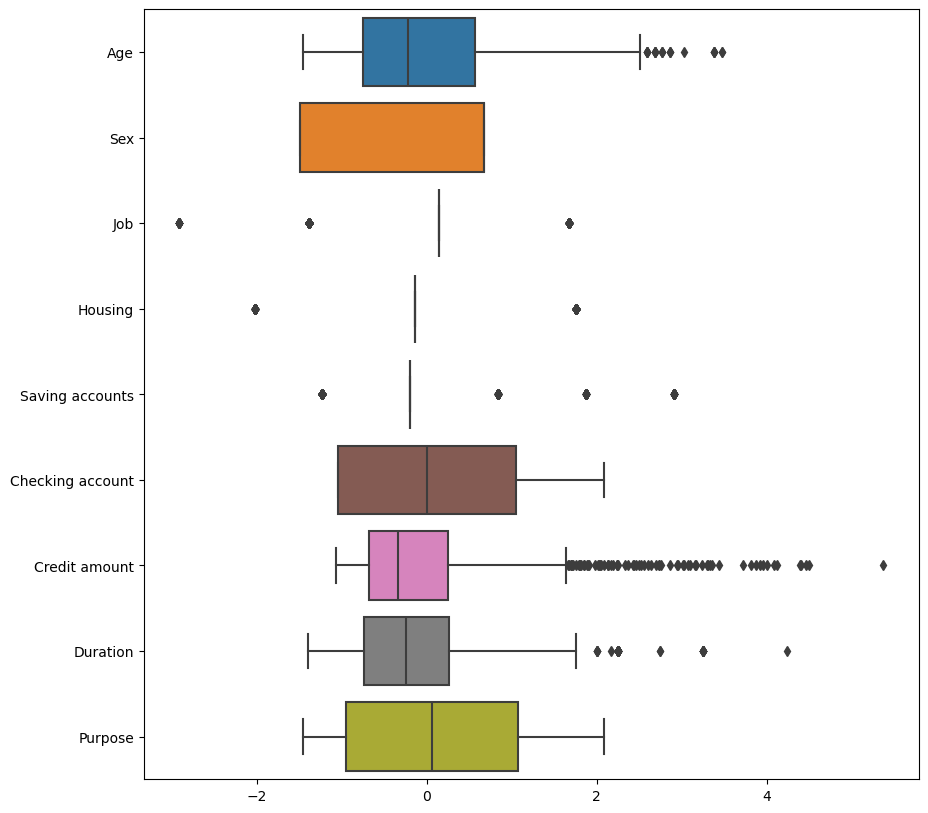

In [33]:
plt.figure(figsize=(10,10))
sns.boxplot(data=df_scaled, orient='h');

## 1. K-Means clustering

Подберем число кластеров

In [34]:
cl_max = 10

In [35]:
inertia = []
for i in range(1,cl_max+1):
    kmeans = KMeans(n_clusters=i, random_state=13, n_init=10).fit(X_scaled)
    inertia_i = kmeans.inertia_
    inertia.append(inertia_i)

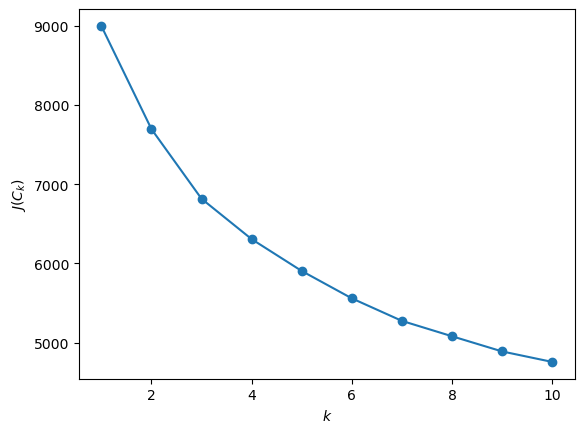

In [36]:
plt.plot(range(1,cl_max+1), inertia, marker='o');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

In [37]:
D = []
for i in range(1, cl_max-1):
    Di = (inertia[i] - inertia[i+1]) / (inertia[i-1] - inertia[i])
    D.append(Di)

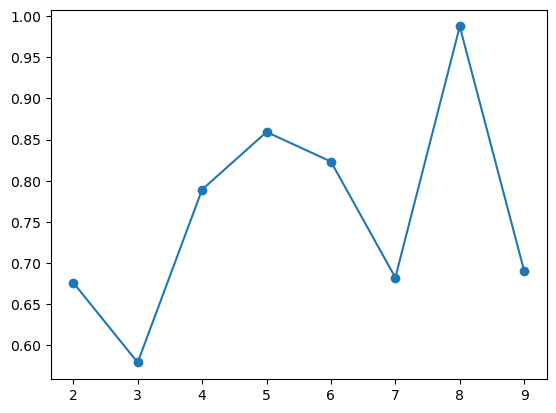

In [38]:
#plt.figure(figsize=(12,6))
plt.plot(range(2, cl_max), D, marker='o');

Выберем 3 кластера

In [39]:
kmeans = KMeans(n_clusters=3, random_state=13, n_init='auto').fit(X_scaled)
labels = kmeans.labels_

Добавим метки к датасету и посмотрим, что у нас получилось

In [40]:
df['labels'] = labels

In [41]:
df.tail()

Age  Sex  Job  Housing  Saving accounts  Checking account  Credit amount  \
995   31    0    1        1                0                -1           1736   
996   40    1    3        1                0                 0           3857   
997   38    1    2        1                0                -1            804   
998   23    1    2        0                0                 0           1845   
999   27    1    2        1                1                 1           4576   

     Duration  Purpose  labels  
995        12        4       1  
996        30        1       2  
997        12        5       0  
998        45        5       2  
999        45        1       2

In [42]:
df['labels'].value_counts(normalize=True).sort_index()

labels
0    0.517
1    0.276
2    0.207
Name: proportion, dtype: float64

In [43]:
#df.groupby('labels').agg([np.median, np.min, np.max]).T.round(2)
df.groupby('labels').median().T.round(2)

labels                 0       1       2
Age                 35.0    28.0    35.0
Sex                  1.0     0.0     1.0
Job                  2.0     2.0     2.0
Housing              1.0     1.0     1.0
Saving accounts      0.0     0.0     0.0
Checking account     0.0     0.0     0.0
Credit amount     1936.0  1766.5  6872.0
Duration            15.0    15.0    36.0
Purpose              4.0     4.0     1.0

KMeans разделил клиентскую базу на следующие группы:

0. Эконом-класс (~ 52%). Клиенты постарше с небольшой суммой кредита на небольшой срок;
1. Группа риска (~ 28%). Молодые клиенты с небольшой суммой кредита на небольшой срок;
2. Бизнес-класс (~ 20%). Клиенты с большой суммой кредита и на длительный срок;

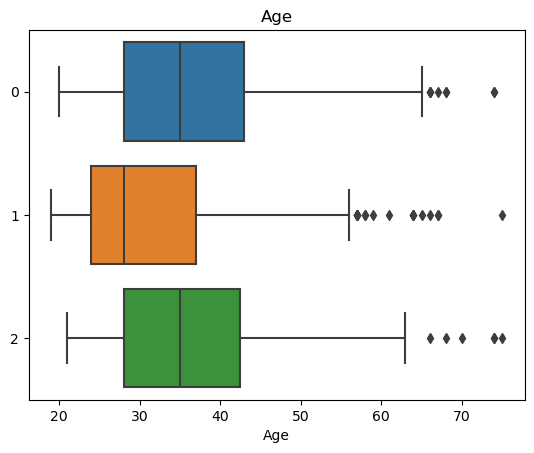

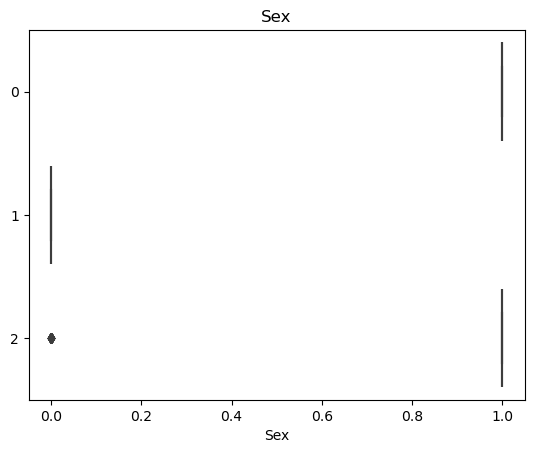

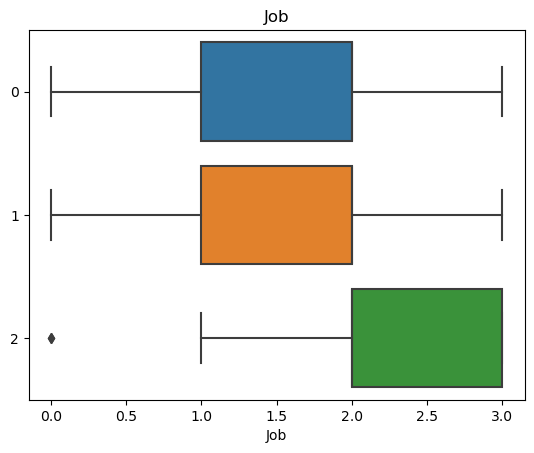

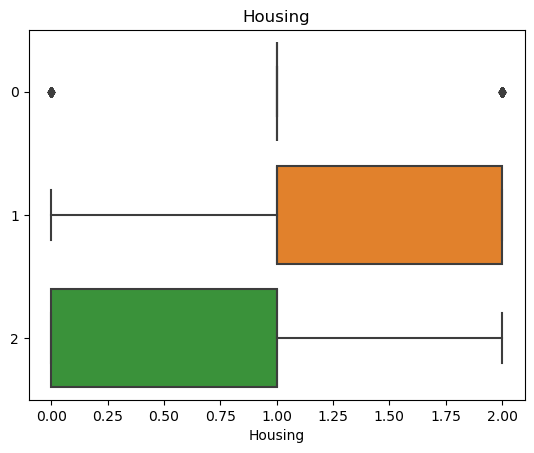

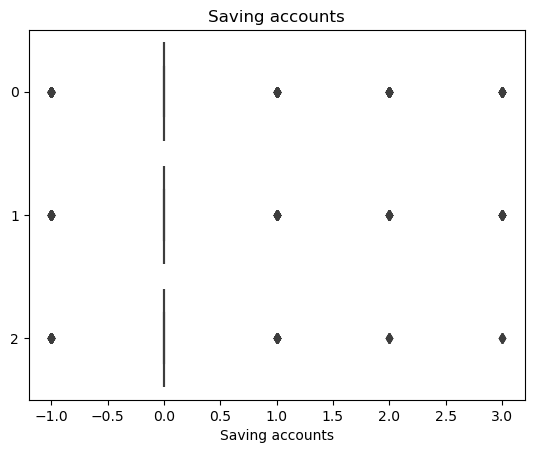

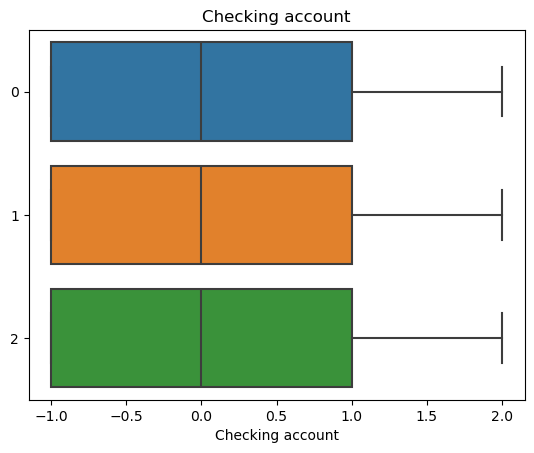

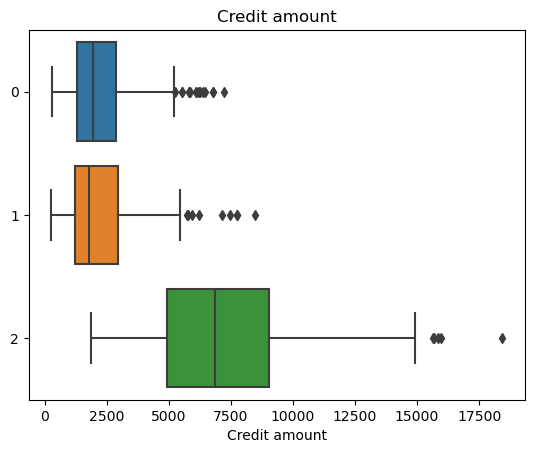

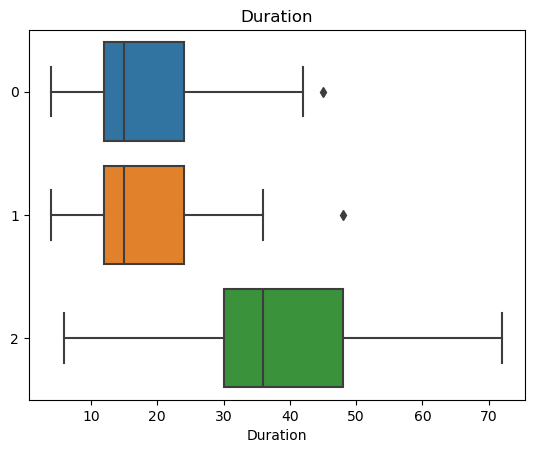

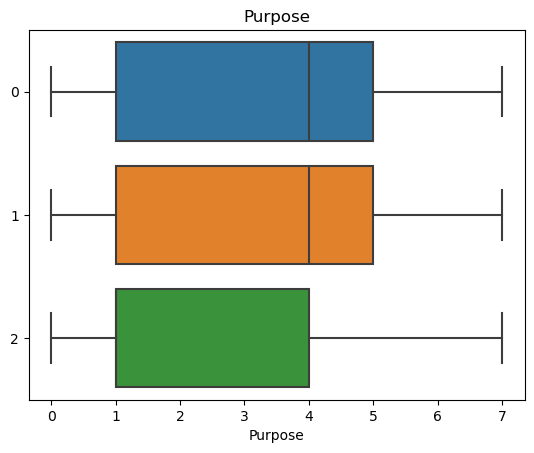

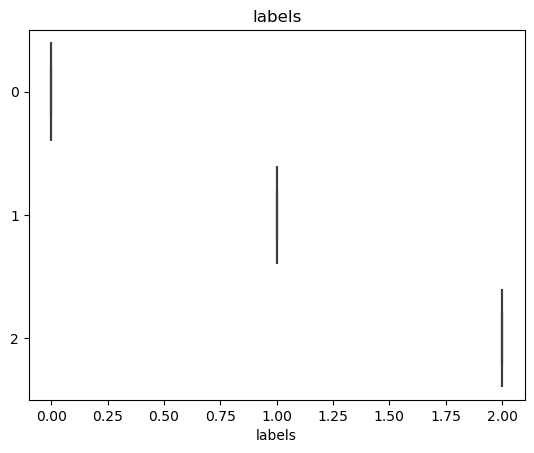

In [44]:
for col in df.columns:
    sns.boxplot(data=df, x=col, y=labels, orient='h')
    plt.title(col)
    plt.show();

### 1.1 PCA Dimensionality Reduction & Visualization

In [45]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [46]:
X_scaled.shape

(1000, 9)

In [47]:
X_pca.shape

(1000, 2)

In [48]:
pca.components_

array([[ 0.16421432,  0.24524452,  0.35587341, -0.32655845, -0.14129389,
         0.00438417,  0.57590558,  0.54309791, -0.18164997],
       [ 0.61766954,  0.42087314, -0.12237451, -0.49079094,  0.022586  ,
        -0.12099807, -0.27470414, -0.3058455 , -0.03666574]])

In [49]:
pca.explained_variance_

array([1.96817031, 1.36463171])

In [50]:
pca.explained_variance_ratio_

array([0.2184669 , 0.15147412])

In [51]:
cumsum = np.cumsum(pca.explained_variance_ratio_)

In [52]:
cumsum

array([0.2184669 , 0.36994102])

Две компоненты объясняют только ~ 37% вариации...

In [53]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.9) + 1
d

1

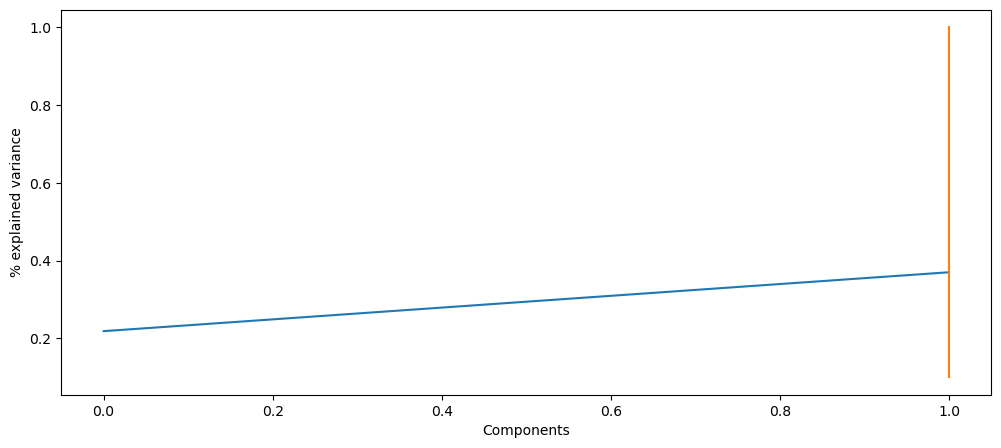

In [54]:
plt.figure(figsize=(12, 5))
plt.plot(cumsum)
plt.plot([d, d], [0.1, 1])
plt.xlabel("Components")
plt.ylabel("% explained variance")
plt.show()

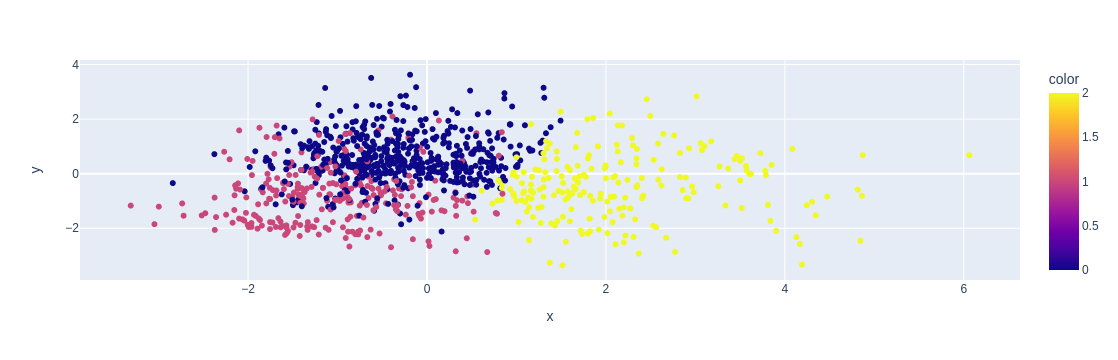

In [55]:
px.scatter(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    color=labels,
)

### 1.2 TSNE Dimensionality Reduction & Visualization

In [56]:
tsne = TSNE(n_components=2, random_state=13)

In [57]:
X_tsne = tsne.fit_transform(X_scaled)

In [58]:
X_scaled.shape

(1000, 9)

In [59]:
X_tsne.shape

(1000, 2)

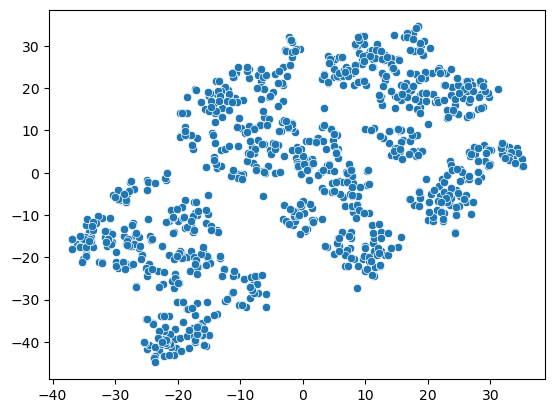

In [60]:
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1]);

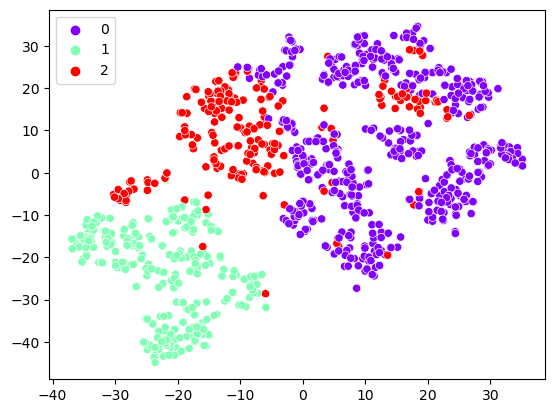

In [61]:
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=labels, palette='rainbow');

### 1.3 UMAP Dimensionality Reduction & Visualization

In [62]:
reducer = umap.UMAP()

In [63]:
X_scaled.shape

(1000, 9)

In [64]:
X_umap = reducer.fit_transform(X_scaled)
X_umap.shape

(1000, 2)

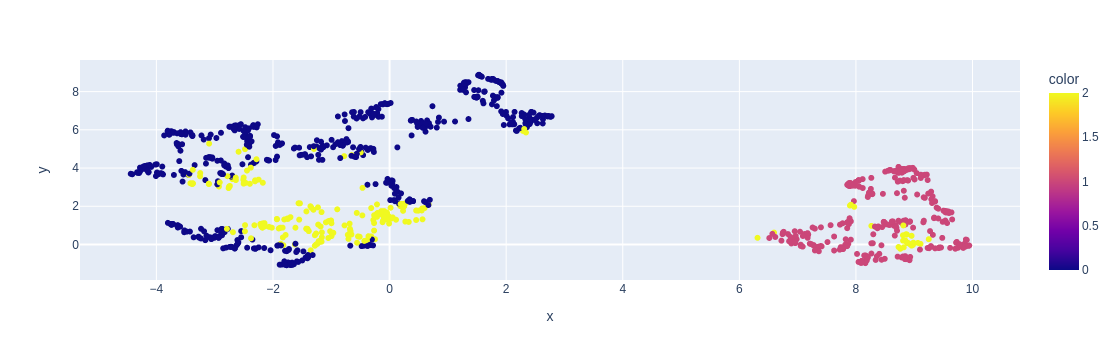

In [65]:
px.scatter(
    x=X_umap[:, 0],
    y=X_umap[:, 1],
    color=labels,
)

## 2. Agglomerative Clustering

In [66]:
df.drop('labels', axis=1, inplace=True)

In [67]:
df.tail()

Age  Sex  Job  Housing  Saving accounts  Checking account  Credit amount  \
995   31    0    1        1                0                -1           1736   
996   40    1    3        1                0                 0           3857   
997   38    1    2        1                0                -1            804   
998   23    1    2        0                0                 0           1845   
999   27    1    2        1                1                 1           4576   

     Duration  Purpose  
995        12        4  
996        30        1  
997        12        5  
998        45        5  
999        45        1

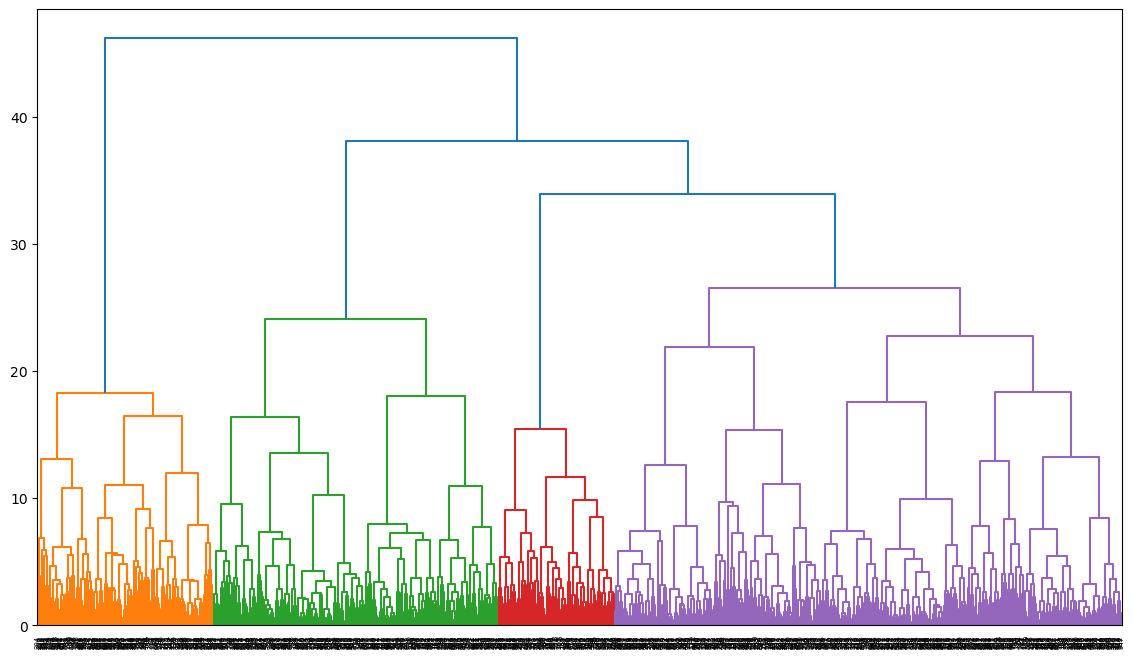

In [68]:
plt.figure(figsize=(14,8))
linkage_ = linkage(X_scaled, method='ward')
dendrogram_ = dendrogram(linkage_)

Выберем три кластера

In [69]:
agg = AgglomerativeClustering(n_clusters=3).fit(X)
labels = agg.labels_

In [70]:
df['labels'] = labels

In [71]:
df['labels'].value_counts(normalize=True).sort_index()

labels
0    0.779
1    0.056
2    0.165
Name: proportion, dtype: float64

In [72]:
df.groupby('labels').median().T.round(2)

labels                 0        1       2
Age                 33.0     34.5    34.0
Sex                  1.0      1.0     1.0
Job                  2.0      2.0     2.0
Housing              1.0      1.0     1.0
Saving accounts      0.0      0.0     0.0
Checking account     0.0      0.0     0.0
Credit amount     1867.0  11191.0  6260.0
Duration            15.0     36.0    30.0
Purpose              4.0      1.0     1.0

Agglomerative Clustering разделил клиентскую базу следующим образом:

0. Эконом-класс (~ 78%). Клиенты с небольшой суммой кредита на самый короткий срок;
1. Первый класс (~ 5%). Клиенты с максимальной суммой кредита на самый длительный срок;
2. Бизнес-класс (~ 17%). Клиенты с большой суммой кредита и на длительный срок;

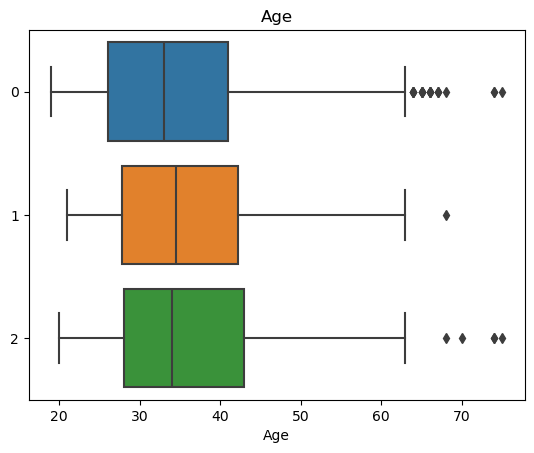

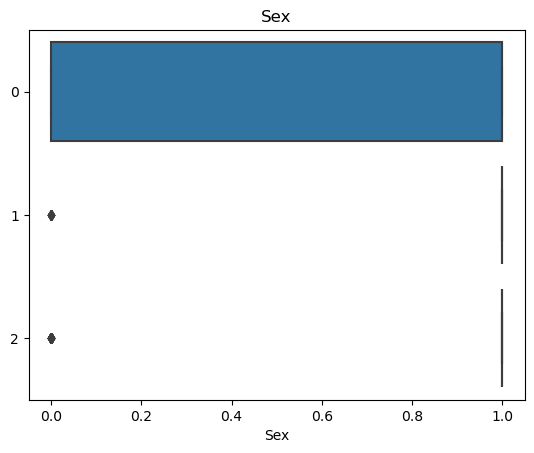

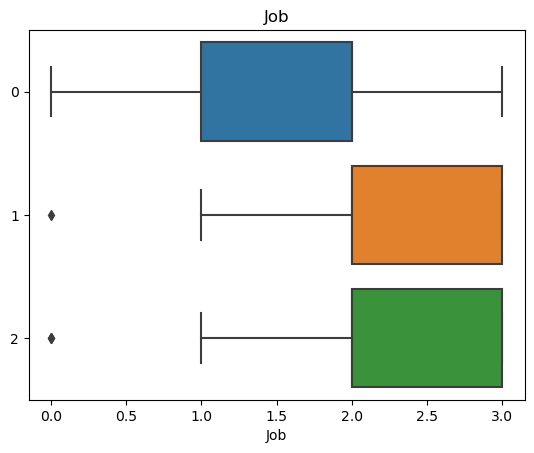

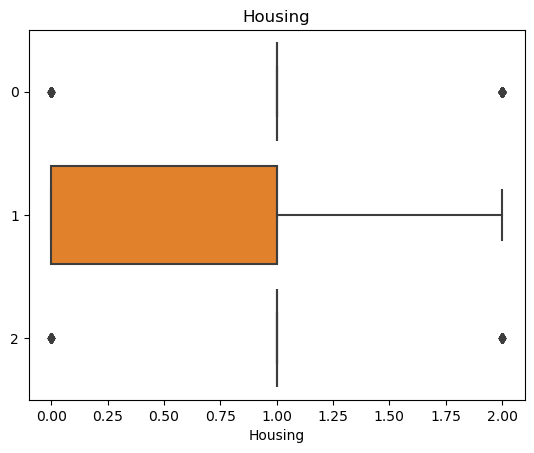

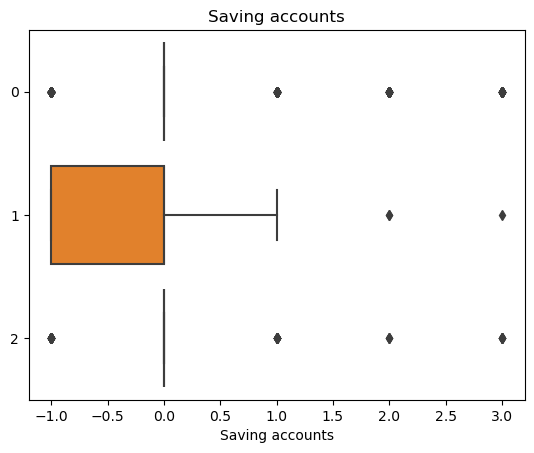

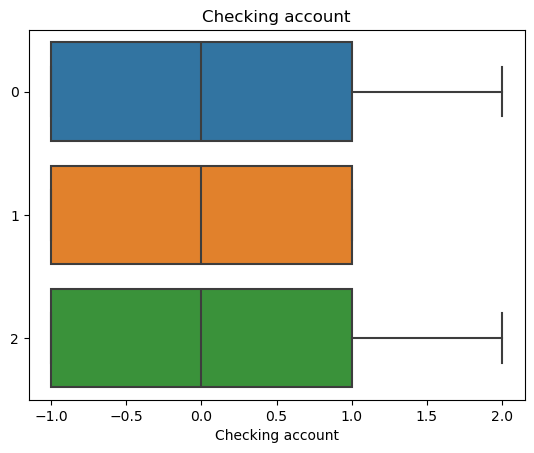

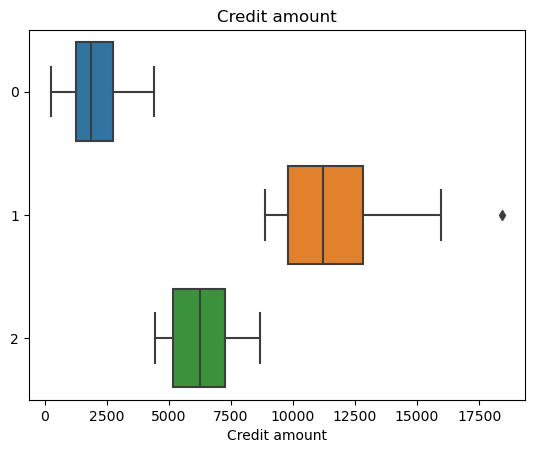

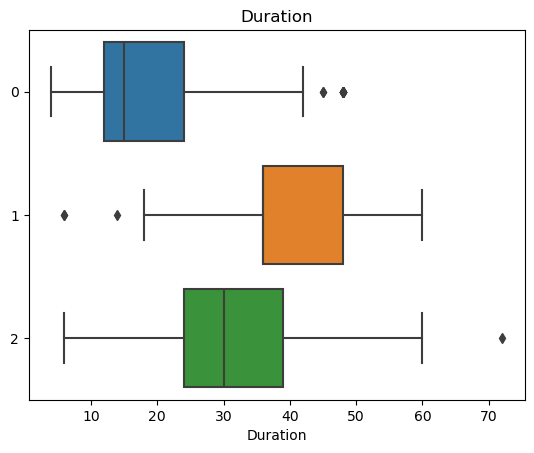

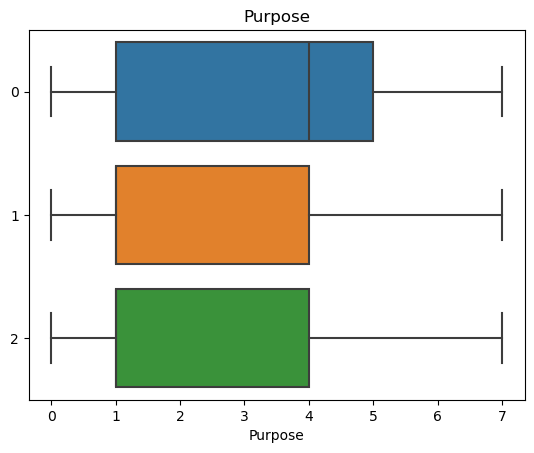

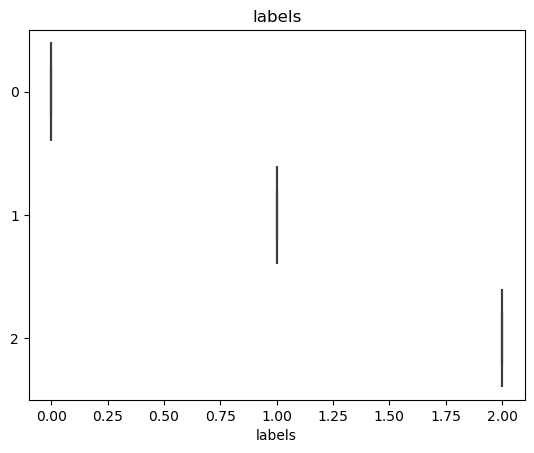

In [73]:
for col in df.columns:
    sns.boxplot(data=df, x=col, y=labels, orient='h')
    plt.title(col)
    plt.show();

### 2.1 PCA Dimensionality Reduction

In [74]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [75]:
X_pca.shape

(1000, 2)

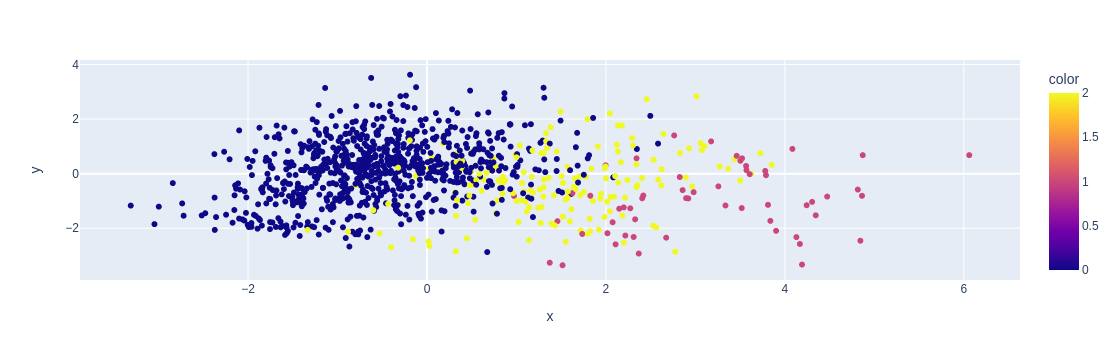

In [76]:
px.scatter(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    color=labels,
)

### 2.2 TSNE Dimensionality Reduction

In [77]:
tsne = TSNE(n_components=2, random_state=13)

In [78]:
X_tsne = tsne.fit_transform(X_scaled)

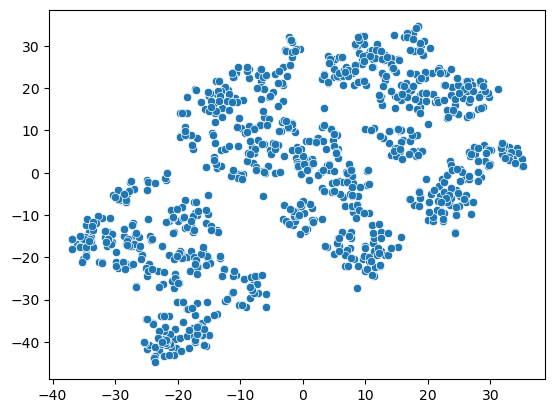

In [79]:
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1]);

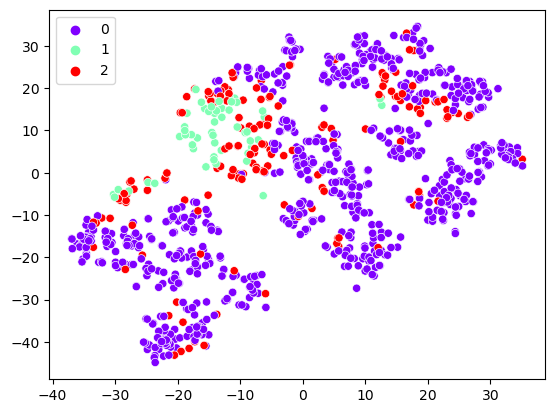

In [80]:
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=labels, palette='rainbow');

### 2.3 UMAP Dimensionality Reduction

In [81]:
reducer = umap.UMAP()

In [82]:
X_scaled.shape

(1000, 9)

In [83]:
X_umap = reducer.fit_transform(X_scaled)
X_umap.shape

(1000, 2)

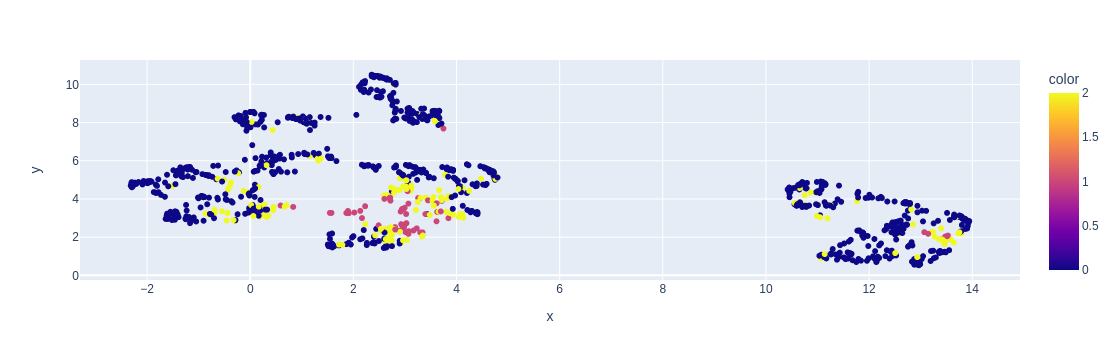

In [84]:
px.scatter(
    x=X_umap[:, 0],
    y=X_umap[:, 1],
    color=labels,
)

## 3. DBSCAN Clustering

In [85]:
df.drop('labels', axis=1, inplace=True)

Определим функцию для отображения графиков зависимости числа кластеров и silhouette_score от размера epsilon-окрестности

In [86]:
def dbscan_clustering(eps_range, X):
    eps_range = eps_range
    silhouette = []
    clusters = []
    for i in tqdm(eps_range):
        dbscan = DBSCAN(eps=i).fit(X)
        labels = dbscan.labels_
        uniq_labels = np.unique(labels)
        n_clusters = len(uniq_labels[uniq_labels != -1])
        if n_clusters > 1:
            score = silhouette_score(X, labels)
        else:
            score = 0
        silhouette.append(score)
        clusters.append(n_clusters)
        
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.plot(eps_range, silhouette, marker='o', color=color)
    ax1.set_xlabel('eps')
    ax1.set_ylabel('silhouette', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.plot(eps_range, clusters, marker='o', color=color)
    ax2.set_ylabel('n_clusters', color=color)  
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

100%|███████████████████████████████████████████| 29/29 [00:01<00:00, 27.77it/s]


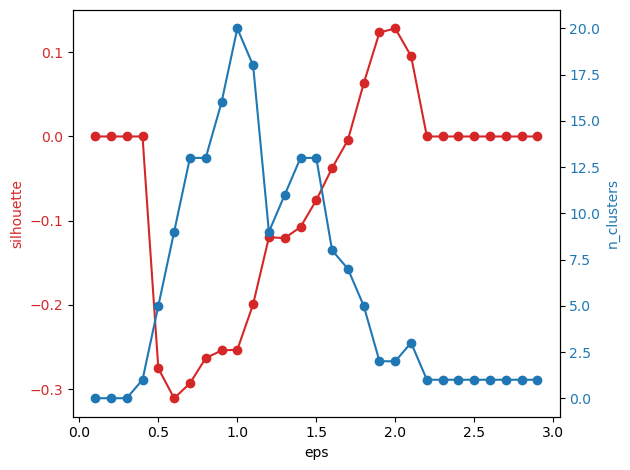

In [87]:
eps_range = np.arange(0.1,3,0.1)
dbscan_clustering(eps_range, X_scaled)

100%|███████████████████████████████████████████| 36/36 [00:01<00:00, 27.02it/s]


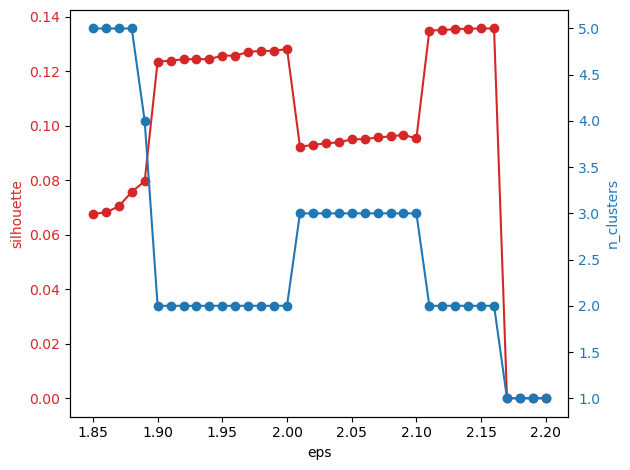

In [88]:
eps_range = np.arange(1.85,2.2,0.01)
dbscan_clustering(eps_range, X_scaled)

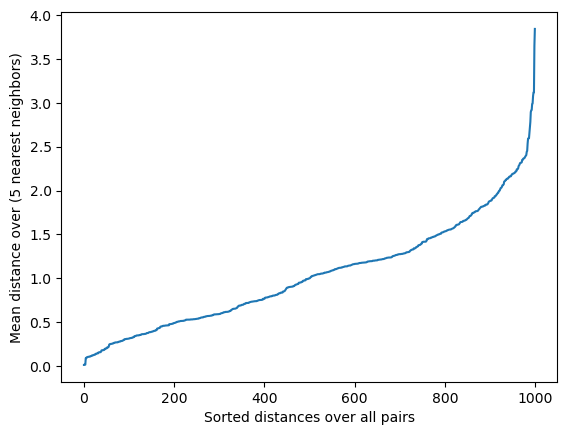

In [89]:
neighbors = NearestNeighbors(n_neighbors=5)
nbrs = neighbors.fit(X_scaled)
distance, indices = nbrs.kneighbors(X_scaled)

distance = np.sort(distance, axis=0)
distance = distance[:,1]

plt.plot(distance);

plt.xlabel("Sorted distances over all pairs")
plt.ylabel("Mean distance over (5 nearest neighbors)")

plt.show()

Выберем epsilon равное 2.05, соответствующее трем кластерам

In [90]:
dbscan = DBSCAN(eps=2.05).fit(X_scaled)
labels = dbscan.labels_

In [91]:
np.unique(labels)

array([-1,  0,  1,  2])

In [92]:
df['labels'] = labels

In [93]:
df['labels'].value_counts(normalize=True).sort_index()

labels
-1    0.110
 0    0.628
 1    0.257
 2    0.005
Name: proportion, dtype: float64

In [94]:
df.groupby('labels').median().T.round(2)

labels                -1       0       1       2
Age                 40.0    35.0    28.0    35.0
Sex                  1.0     1.0     0.0     1.0
Job                  2.0     2.0     2.0     3.0
Housing              1.0     1.0     1.0     2.0
Saving accounts      0.0     0.0     0.0     0.0
Checking account     1.0     0.0     0.0     1.0
Credit amount     6443.5  2324.0  1858.0  7057.0
Duration            24.0    18.0    18.0    36.0
Purpose              1.0     3.0     4.0     1.0

DBSCAN разделил клиентскую базу следующим образом:

0. Эконом-класс (~ 63%). Клиенты постарше, со средней суммой кредита и небольшой длительностью;
1. Группа риска (~ 25.5%). Молодые клиенты с минимальной суммой кредита на короткий срок;
2. Бизнес-класс (~ 0,5%). Клиенты с большой суммой кредита и на длительный срок;

-1. Не классифицированы (!) ~ 11%. Клиенты старшего возраста с большой суммой и длительностью кредита;

В целом похоже на результаты Agglomerative Clustering, но 11% клиентов, не отнесенных к тому или иному кластеру, применительно к задаче сегментации клиентской базы - неприемлемый результат.


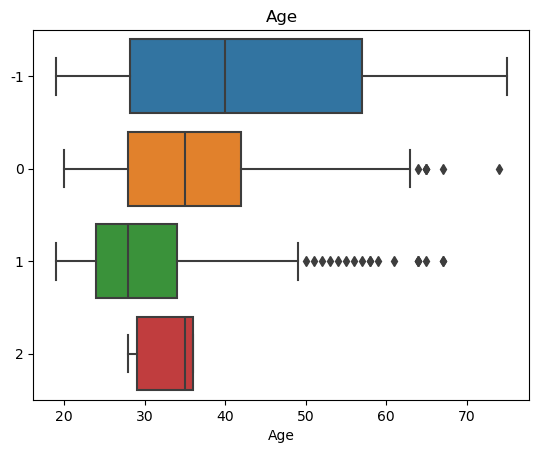

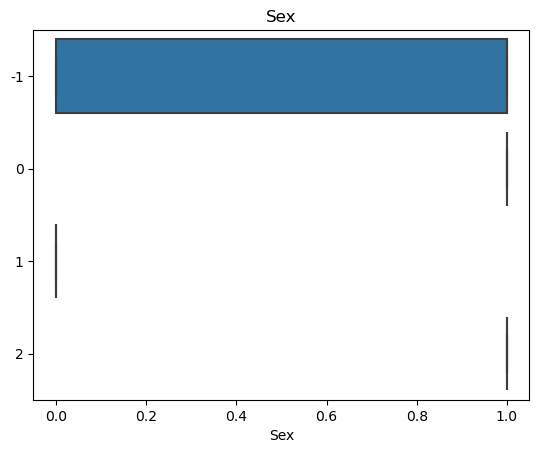

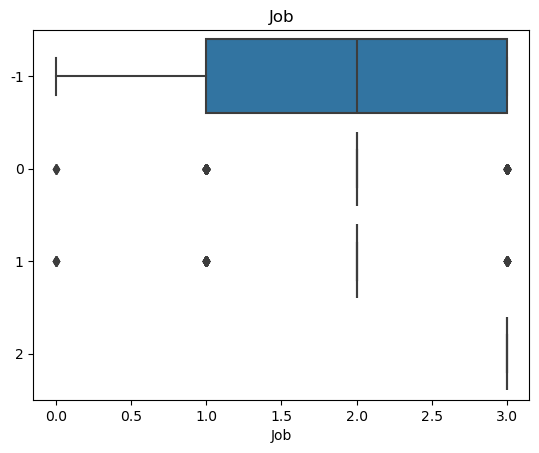

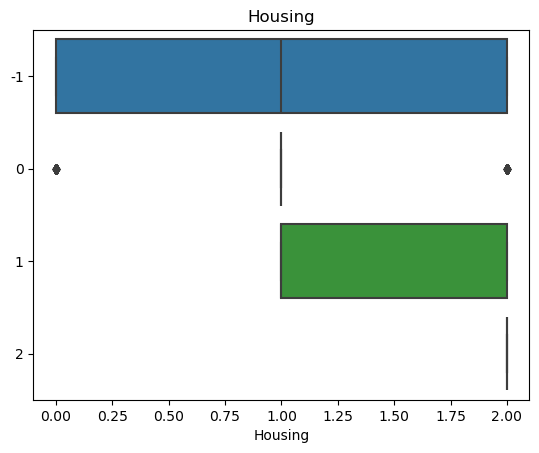

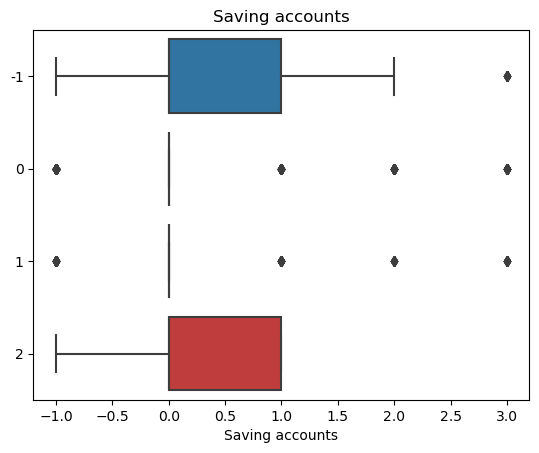

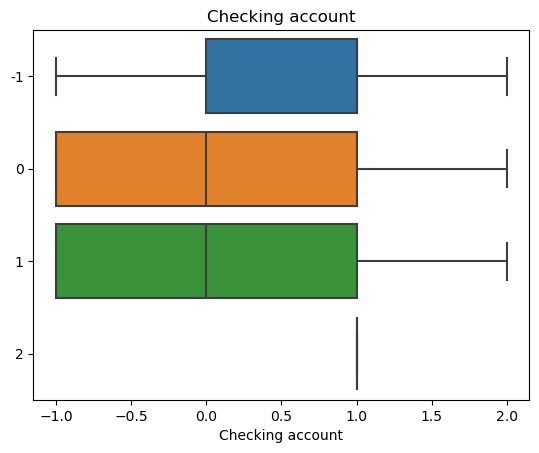

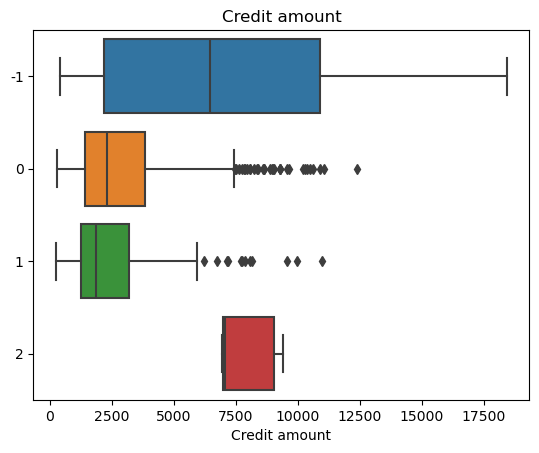

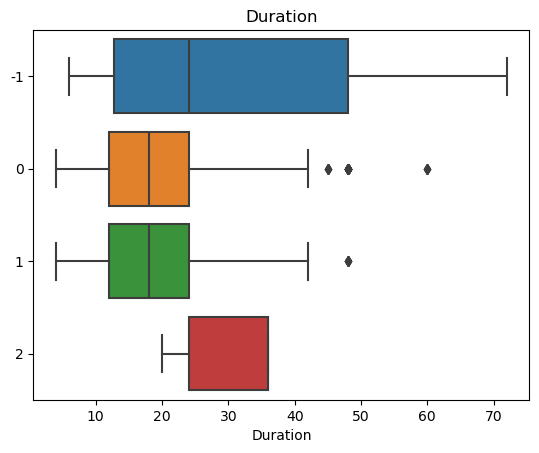

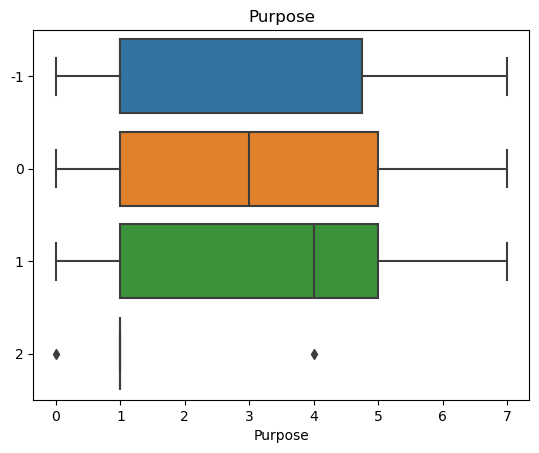

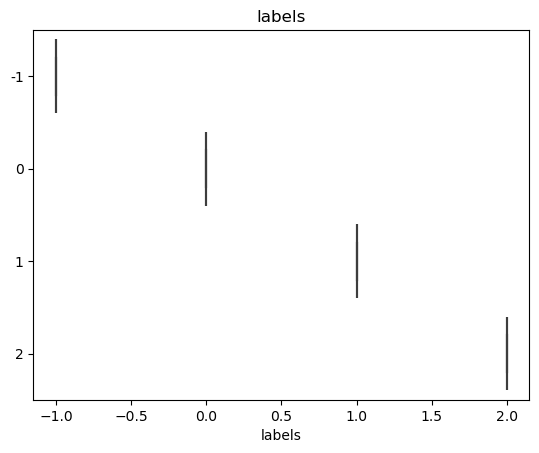

In [95]:
for col in df.columns:
    sns.boxplot(data=df, x=col, y=labels, orient='h')
    plt.title(col)
    plt.show();

### 3.1 PCA Dimensionality Reduction

In [96]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [97]:
X_pca.shape

(1000, 2)

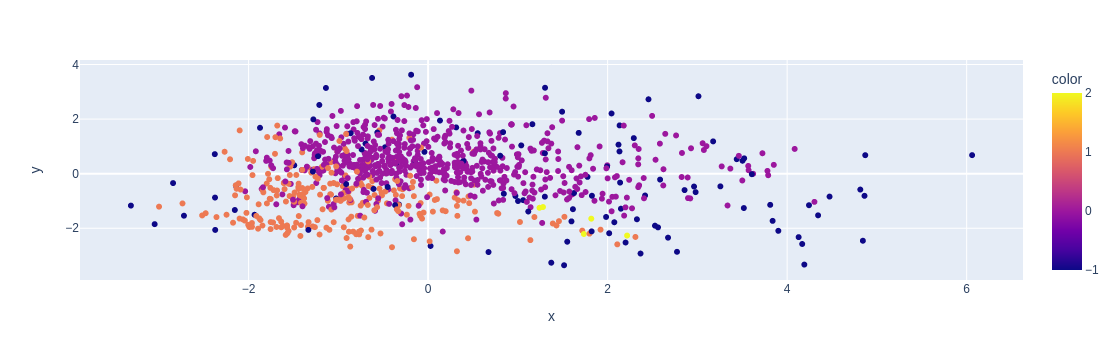

In [98]:
px.scatter(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    color=labels,
)

### 3.2 TSNE Dimensionality Reduction

In [99]:
tsne = TSNE(n_components=2, random_state=13)

In [100]:
X_tsne = tsne.fit_transform(X_scaled)

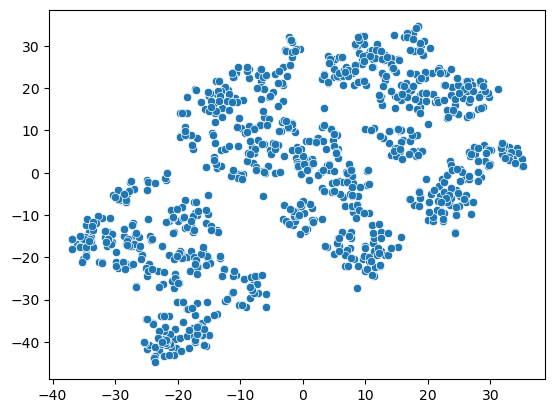

In [101]:
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1]);

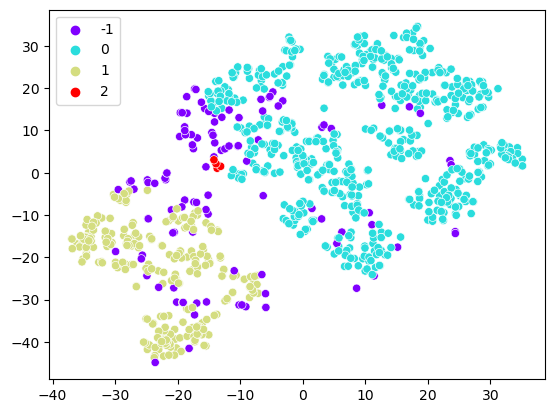

In [102]:
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=labels, palette='rainbow');

### 3.3 UMAP Dimensionality Reduction

In [103]:
reducer = umap.UMAP()

In [104]:
X_scaled.shape

(1000, 9)

In [105]:
X_umap = reducer.fit_transform(X_scaled)
X_umap.shape

(1000, 2)

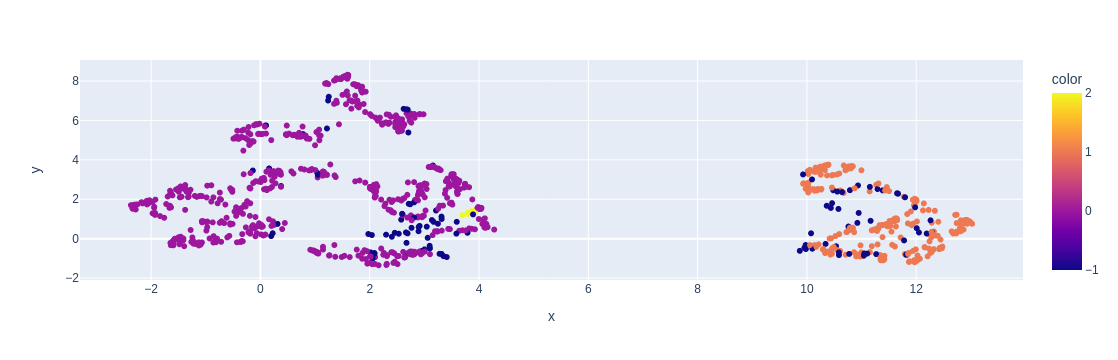

In [106]:
px.scatter(
    x=X_umap[:, 0],
    y=X_umap[:, 1],
    color=labels,
)

## Итоговые выводы

- Различные алгоритмы разделили клиентскую базу на кластеры несколько по разному, при этом, по метрикам близким к оптимальному количеству было три кластера; 
- Качество кластеризации невысокое и четкие границы отсутствуют;  
- DBSCAN не смог классифицировать 11% клиентов, видимо, вследствие разреженности данных (слабое место данного алгоритма) и это худший результат из всех участников;